In [1]:
!git clone https://github.com/google/svcca.git

fatal: destination path 'svcca' already exists and is not an empty directory.


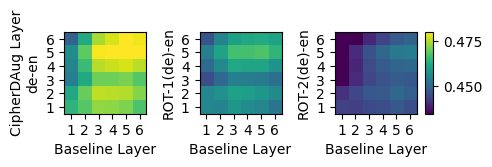

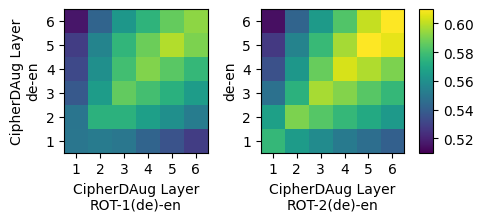

In [2]:
import sys
sys.path.append("./svcca")
import cca_core
import pwcca

import torch
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

models = dict()
vocabs = dict()

basedir = "./"

# Load models
for expt in ["iwslt14_dex_2keys_kl", "14_de_en_base"]:
    with open(f"{basedir}/embedding_plots/{expt}.vocab") as fp:
        vocab = fp.read().strip().split("\n")
        vocab = [line.split("\t")[0] for line in vocab]
    vocabs[expt] = vocab
    
    model = torch.load(f"{basedir}/embedding_plots/{expt}/checkpoint_best.pt")
    models[expt] = model['model']['encoder.embed_tokens.weight']
    
# Load hidden states from file
embeds = defaultdict(lambda:defaultdict(dict))
ids    = defaultdict(list)
for model in ["iwslt14_dex_2keys_kl", "iwslt14_dex_2keys_kl_de1", "iwslt14_dex_2keys_kl_de2", "14_de_en_base"]:
    for layer in range(7):
        for fnum in range(4):
            fp = np.load(f"{basedir}/hidden/{model}/{fnum}.npz", allow_pickle=True) 
            es = fp["arr"][layer].numpy()
            for i, id in enumerate(fp["ids"].tolist()):
                embeds[model][layer][id] = es[:,i,:]
                
# Compute layerwise PWCCA across model pairs
mats = dict()
ms = [
    ("base", "14_de_en_base"),
    ("cipher", "iwslt14_dex_2keys_kl"),
    ("de1", "iwslt14_dex_2keys_kl_de1"),
    ("de2", "iwslt14_dex_2keys_kl_de2"),
]
for i, (l1, m1) in enumerate(ms):
    for j, (l2, m2) in enumerate(ms):
        if j <= i or i >= 2:
            continue
    
        mat = [[0 for _ in range(7)] for _ in range(7)]
        shared_ids = [id for id in embeds[m1][0] if id in embeds[m2][0]]
        for layer1 in range(7):
            for layer2 in range(7):
                X = np.concatenate([embeds[m1][layer1][id][0:15,:] for id in shared_ids]).T
                Y = np.concatenate([embeds[m2][layer2][id][0:15,:] for id in shared_ids]).T
                pwcca_mean, w, _ = pwcca.compute_pwcca(
                    X, 
                    Y,
                    epsilon=1e-10
                )
                if layer1 == 0 and layer2 == 0:
                    rand_mean, w, _ = pwcca.compute_pwcca(
                        np.random.rand(*X.shape), 
                        np.random.rand(*Y.shape),
                        epsilon=1e-10
                    )
                mat[layer1][layer2] = pwcca_mean
        mats[l1,l2] = np.array(mat)
        

# Plot CCA as heatmap
VMIN=0.435
VMAX=0.48
plt.figure(figsize=(5,4))
plt.subplot(1,3,1)
plt.ylabel("CipherDAug Layer\nde-en")
plt.xlabel("Baseline Layer")
plt.imshow(mats["base", "cipher"][1:,1:][::-1], 
           vmin=VMIN, vmax=VMAX
)
plt.xticks(range(6), range(1,7))
plt.yticks(range(6), range(6,0,-1))
plt.subplot(1,3,2)
plt.ylabel("ROT-1(de)-en")
plt.xlabel("Baseline Layer")
plt.imshow(mats["base", "de1"][1:,1:][::-1], 
           vmin=VMIN, vmax=VMAX
)
plt.xticks(range(6), range(1,7))
plt.yticks(range(6), range(6,0,-1))
ax=plt.subplot(1,3,3)
plt.ylabel("ROT-2(de)-en")
plt.xlabel("Baseline Layer")
im=plt.imshow(mats["base", "de2"][1:,1:][::-1], 
              vmin=VMIN, vmax=VMAX
 )
plt.xticks(range(6), range(1,7))
plt.yticks(range(6), range(6,0,-1))
cax=ax.inset_axes([1.1,0,0.1,1], transform=ax.transAxes)
plt.colorbar(im, ax=ax, cax=cax)
plt.tight_layout()
plt.show()

VMIN=0.51
VMAX=0.61
plt.figure(figsize=(5,4))
plt.subplot(1,2,1)
plt.xlabel("CipherDAug Layer\nROT-1(de)-en")
plt.ylabel("CipherDAug Layer\nde-en")
plt.imshow(mats["cipher","de1"][1:,1:][::-1], vmin=VMIN, vmax=VMAX)
plt.xticks(range(6), range(1,7))
plt.yticks(range(6), range(6,0,-1))
ax=plt.subplot(1,2,2)
plt.xlabel("CipherDAug Layer\nROT-2(de)-en")
plt.ylabel("de-en")
im=plt.imshow(mats["cipher","de2"][1:,1:][::-1], vmin=VMIN, vmax=VMAX)
plt.xticks(range(6), range(1,7))
plt.yticks(range(6), range(6,0,-1))
cax=ax.inset_axes([1.1,0,0.1,1], transform=ax.transAxes)
plt.colorbar(im, ax=ax, cax=cax)
plt.tight_layout()
plt.show()

[(336, '▁hier'), (1865, '▁ist'), (1667, '▁es'), (9, '▁nöt'), (213, 'ig'), (9786, ','), (2215, '▁das'), (9786, ','), (624, '▁was'), (1836, '▁wir'), (105, '▁unter'), (6, '▁polit'), (1, 'ically'), (1, '▁correct'), (3, 'ness'), (57, '▁verstehen'), (9786, ','), (187, '▁immer'), (149, '▁wieder'), (16, '▁anzu'), (13, 'bringen'), (6696, '.')]
2061.681818181818
1


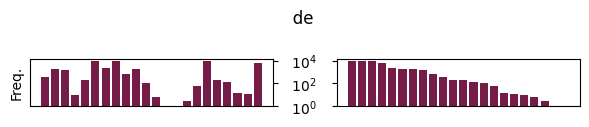

[(336, '▁ijfs'), (1865, '▁jtu'), (1669, '▁ft'), (9, '▁oøu'), (233, 'jh'), (9786, ','), (2215, '▁ebt'), (9786, ','), (626, '▁xbt'), (1838, '▁xjs'), (116, '▁voufs'), (6, '▁qpmju'), (33, 'jd'), (66, 'bmm'), (158, 'z'), (74, '▁d'), (96, 'ps'), (87, 'sf'), (27, 'du'), (126, 'o'), (31, 'ftt'), (57, '▁wfstufifo'), (9786, ','), (188, '▁jnnfs'), (149, '▁xjfefs'), (19, '▁boßv'), (13, 'csjohfo'), (6696, '.')]
1646.107142857143
6


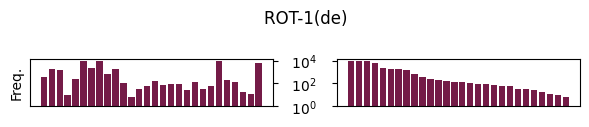

[(336, '▁jkgt'), (1865, '▁kuv'), (1669, '▁gu'), (9, '▁pú'), (50, 'vki'), (9786, ','), (2216, '▁fcu'), (9786, ','), (624, '▁ycu'), (1837, '▁ykt'), (119, '▁wpvgt'), (6, '▁rqnkv'), (44, 'ke'), (49, 'cnn'), (137, 'ß'), (58, '▁e'), (118, 'qt'), (104, 't'), (6, 'gev'), (98, 'p'), (26, 'guu'), (57, '▁xgtuvgjgp'), (9786, ','), (187, '▁koogt'), (149, '▁ykgfgt'), (33, '▁cpàw'), (18, 'dtkpigp'), (6696, '.')]
1638.1785714285713
6


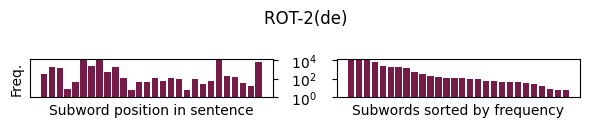

In [3]:
# Compare subword rarity between plaintext and rotated inputs:

from collections import Counter
vocab_counts = np.load(f"{basedir}/vocab_counts.npz", allow_pickle=True)

freqs = dict()
for key in vocab_counts:
    freqs[key] = Counter(sum(vocab_counts[key], []))
    
diffs = [
    sum([freqs["de0"][sw] for sw in s1[:-1]])/len(s1)
     - sum([freqs["de2"][sw] for sw in s2[:-1]])/len(s2)
    for s1, s2 in zip(vocab_counts["de0"],vocab_counts["de2"])
]

import matplotlib.pyplot as plt
nsents=1
for start in np.argsort(diffs)[::-1][:nsents]:
    for j, key in enumerate(["de0", "de1", "de2"]):
        fig=plt.figure(figsize=(6,1.25))
        fig.suptitle(
            ("   de" if key=="de0" else "    ROT-1(de)" if key=="de1" else "    ROT-2(de)")
        )
        sentence = vocab_counts[key][start]
        counts = [freqs[key][sw] for sw in sentence]
        print(list(zip(counts,sentence)))
        print(np.mean(counts))
        print(np.min(counts))
        ax=plt.subplot(1,2,1)
        ax.yaxis.set_label_position("left")
        plt.ylabel("Freq.")
        if key == "de2":
            plt.xlabel("Subword position in sentence")
        plt.bar(range(len(counts)), counts, color="#741b47")
        plt.xticks([],[])
        ax.yaxis.tick_right()
        ax.set_yscale("log")
        plt.yticks([1,100,10000],["  $10^0$","  $10^2$","  $10^4$"])
        plt.ylim(1,15000)
        ax=plt.subplot(1,2,2)
        if key == "de2":
            plt.xlabel("Subwords sorted by frequency")
        plt.bar(range(len(counts)), sorted(counts,reverse=True), color="#741b47")
        plt.xticks([],[])
        plt.ylim(1,15000)
        ax.set_yscale("log")
        plt.yticks([1,100,10000],["","",""])
        plt.tight_layout()
        plt.show()
    print("="*10)
    print()
    print()

In [4]:
mins = defaultdict(list)
for key in vocab_counts:
    for sentence in vocab_counts[key]:
        counts = [freqs[key][sw] for sw in sentence]
        mins[key].append(np.min(counts))
    print(f"Avg. freq. of rarest subword in {key:8}: {np.mean(mins[key]):.2f}")

Avg. freq. of rarest subword in baseline: 8.08
Avg. freq. of rarest subword in de0     : 9.14
Avg. freq. of rarest subword in de1     : 9.76
Avg. freq. of rarest subword in de2     : 9.72
